In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data from the Excel file
file_path = 'FINAL_DATA.xlsx'
data = pd.read_excel(file_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   zip_code                 266 non-null    int64  
 1   neighborhood             266 non-null    object 
 2   community                266 non-null    object 
 3   rent_2024                0 non-null      float64
 4   mean_rent                266 non-null    float64
 5   0br_2019                 265 non-null    float64
 6   0br_2020                 266 non-null    int64  
 7   0br_2021                 266 non-null    int64  
 8   0br_2022                 266 non-null    int64  
 9   0br_2023                 266 non-null    int64  
 10  population               266 non-null    int64  
 11  median_household_income  266 non-null    int64  
 12  unemployment_rate        266 non-null    float64
 13  average_household_size   266 non-null    float64
 14  crime_rate               2

In [2]:
#fill in any missing values and encode categoricals (neighborhoods/community)
data['crime_rate'].fillna(data['crime_rate'].median(), inplace=True)
data['0br_2019'].fillna(data['0br_2019'].median(), inplace=True)
data_encoded = pd.get_dummies(data, columns=['neighborhood', 'community'])

In [3]:
# Define the feature columns (exclude 'rent_2024' from features and other non-relevant features)
features = data_encoded.drop(columns=['rent_2024', 'zip_code'])
target = data_encoded[['0br_2023']].values.ravel()  # Using 2023 rent as the target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)
mse, np.sqrt(mse)

(67.77111111111088, 8.232321125363788)

1. **Mean Squared Error (MSE) - 67.77**: 
   - A lower MSE indicates a better fit of the model to the data. In this case, an MSE of 67.77 suggests that, on average, the square of the error (difference between the predicted and actual rent prices) is 67.77. 
2. **Root Mean Squared Error (RMSE) - 8.23**:
   - The standard deviation of the prediction errors is about 8.23 This indicates that typically, the model's predictions are within 8.23 of the actual rent price. 
   - With an RMSE of 8.23, the model is reasonably accurate in its predictions, considering the variability and range of rent prices. Considering rents are around 1000, an error of 8.23 is less than 1% of the price, which is good.
- This level of precision could be adequate for initial estimates or planning purposes but might need refinement for applications where high precision is critical.

In [4]:
# Fill 'rent_2024' column with the predicted values
rent_2024_predictions = rf.predict(features)
data_encoded['rent_2024'] = rent_2024_predictions

In [5]:
# Define the features to exclude (historical rent prices and mean_rent)
exclude_features = ['mean_rent', '0br_2019', '0br_2020', '0br_2021', '0br_2022', '0br_2023']

# Create a new feature DataFrame excluding the specified columns
features_non_rent = features.drop(columns=exclude_features)

# Split the dataset into training and testing sets without historical rent prices
X_train_non_rent, X_test_non_rent, y_train_non_rent, y_test_non_rent = train_test_split(
    features_non_rent, target, test_size=0.2, random_state=42
)

# Retrain the model with non-rent features
rf_non_rent = RandomForestRegressor(n_estimators=100, random_state=42)
rf_non_rent.fit(X_train_non_rent, y_train_non_rent)

# Extract and display feature importances for the new model
feature_importances_non_rent = rf_non_rent.feature_importances_
importance_df_non_rent = pd.DataFrame({'Feature': features_non_rent.columns, 'Importance': feature_importances_non_rent})
important_features_non_rent = importance_df_non_rent.sort_values(by='Importance', ascending=False).head(10)

important_features_non_rent

,Feature,Importance
11,latino_population,0.533994
1,median_household_income,0.201739
3,average_household_size,0.068337
10,asian_population,0.033064
7,white_population,0.032058
8,black_population,0.019403
0,population,0.018631
6,median_age,0.015955
9,native_population,0.014389
2,unemployment_rate,0.012771


1. Latino Population
Importance: This feature has the highest importance score, indicating a strong correlation between the Latino population in a community and the rental prices for 2023.
Interpretation: Areas with a higher Latino population might be experiencing different economic dynamics, possibly reflecting specific community developments, cultural influences, or economic opportunities that affect rental markets.
2. Median Household Income
Importance: A significant predictor, as income directly influences renting capabilities and preferences.
Interpretation: Higher median incomes usually correspond to higher rent as people can afford to pay more, indicating this as a strong predictor of rent prices.
3. Average Household Size
Importance: Smaller than demographic indicators but still notable.
Interpretation: Larger household sizes could imply a need for bigger rental properties, thus potentially higher rents, or conversely, more shared accommodations leading to lower individual rents.
4. Asian and White Populations
Importance: Both demographic features have modest importance.
Interpretation: Similar to Latino population, these features suggest that racial and ethnic composition might be linked to socioeconomic factors influencing rental prices.
5. Population and Median Age
Importance: Lower but non-trivial importance.
Interpretation: Overall population can indicate the demand pressure in the rental market. Median age might reflect the demographic segment most likely to rent (younger populations).
6. Unemployment Rate
Importance: Least important among the top features.
Interpretation: While intuitively one might expect a higher unemployment rate to correlate with lower rents due to reduced economic activity, its low importance suggests other factors are more dominant.

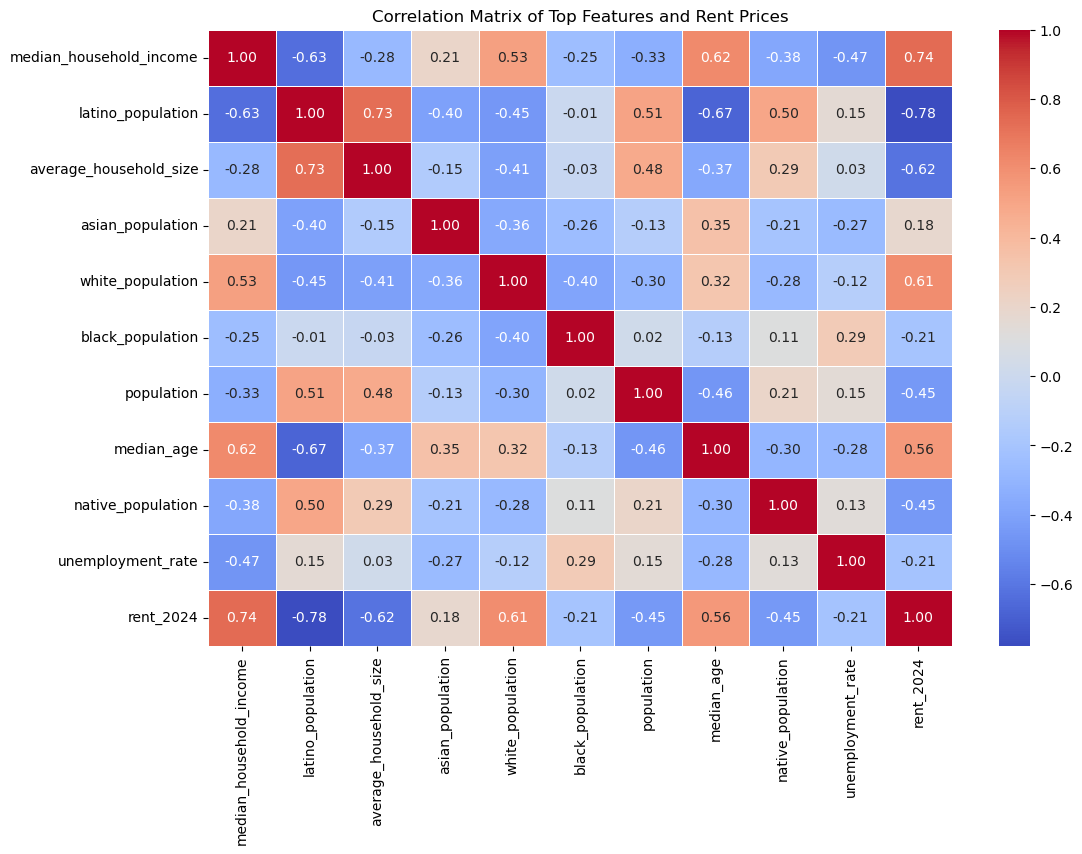

In [13]:
# Compute the correlation matrix for the top features and rent prices
top_features = ['median_household_income', 'latino_population', 'average_household_size', 
                'asian_population', 'white_population', 'black_population', 'population',
                'median_age', 'native_population', 'unemployment_rate', 'rent_2024']

correlation_matrix = data_encoded[top_features].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Top Features and Rent Prices')
plt.show()


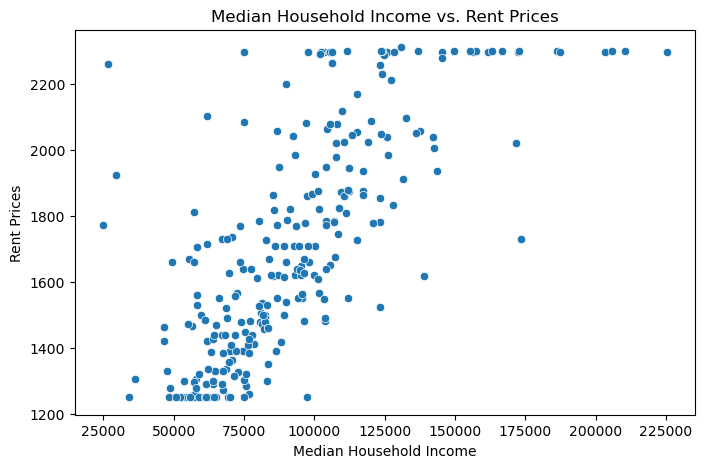

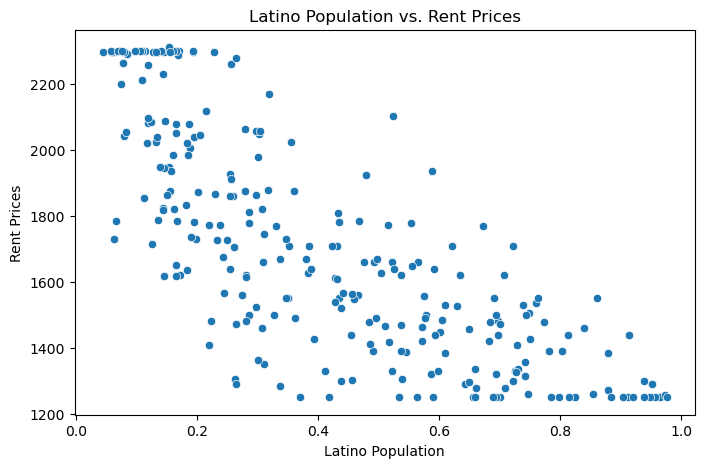

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Scatter plot for Median Household Income vs. Rent Prices
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data_encoded['median_household_income'], y=data_encoded['rent_2024'])
plt.title('Median Household Income vs. Rent Prices')
plt.xlabel('Median Household Income')
plt.ylabel('Rent Prices')
plt.show()

# Scatter plot for Latino Population vs. Rent Prices
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data_encoded['latino_population'], y=data_encoded['rent_2024'])
plt.title('Latino Population vs. Rent Prices')
plt.xlabel('Latino Population')
plt.ylabel('Rent Prices')
plt.show()


Time Series Analysis

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data has columns '0br_2019', '0br_2020', '0br_2021', '0br_2022', '0br_2023' representing annual rents
# Create a DataFrame for time series analysis
years = ['0br_2019', '0br_2020', '0br_2021', '0br_2022', '0br_2023']
time_series_data = pd.DataFrame(data[years].mean()).reset_index()
time_series_data.columns = ['Year', 'Average_Rent']

# Convert 'Year' to datetime
time_series_data['Year'] = pd.to_datetime(time_series_data['Year'].str.replace('0br_', '').astype(int), format='%Y')

# Set 'Year' as the index
time_series_data.set_index('Year', inplace=True)


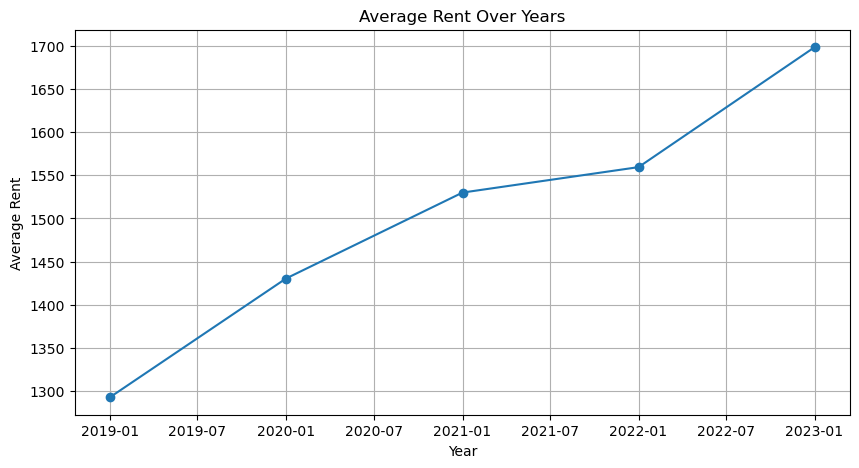

In [17]:
# Plotting the average rent over years
plt.figure(figsize=(10, 5))
plt.plot(time_series_data.index, time_series_data['Average_Rent'], marker='o')
plt.title('Average Rent Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rent')
plt.grid(True)
plt.show()
